In [23]:
from psychrnn.tasks.task import Task
import numpy as np
from matplotlib import pyplot as plt

In [81]:
N_in = 4
N_out = 2; 
dt = 10
tau  = 20
T = 2000
coherence=[-0.9, 0.9]
side=0.5
noise=0.25
target_onset=[250, 500]
checker_onset=[500, 1000]
accumulation_mask=300
decision_threshold = 0.7
post_decision_baseline = 0.2
wait = 0.2
hi = 1
lo = 0


# define trial parameters
params = {}

params["coherence"] = (
    coherence
    if len(coherence) == 1
    else np.random.uniform(coherence[0], coherence[1])
)
params["side"] = int(np.random.random() < side)
params["noise"] = noise
params["accumulation_mask"] = accumulation_mask
# at a random time between target onset boundary, show target; same for checker onset
params["target_onset"] = np.random.randint(target_onset[0], target_onset[1])
params["checker_onset"] = np.random.randint(checker_onset[0], checker_onset[1])

In [16]:
## define correct side
target_onset = params["target_onset"]
checker_onset = params["checker_onset"]
accumulation_mask = params["accumulation_mask"]
coherence = params["coherence"]
green_side = params["side"]
correct_side = green_side if coherence > 0 else abs(green_side - 1)

## define t: specific time at which it generate the parameters
t = 40



x_t = np.zeros(N_in)
x_t[2:] = (params["noise"] ** 2) * np.sqrt(dt) * np.random.randn(2)
if t > target_onset:
    x_t[0] = 2 * green_side - 1
    x_t[1] = -(2 * green_side - 1)
if t > target_onset + checker_onset:
    x_t[2] += coherence
    x_t[3] -= coherence

# ----------------------------------
# Generate output and mask
# ----------------------------------

y_t = np.zeros(N_out) + wait
if t > target_onset + checker_onset:
    y_t[correct_side] = hi
    y_t[abs(correct_side - 1)] = lo

mask_t = np.ones(N_out)
if (t > target_onset + checker_onset) and (t < target_onset + checker_onset + accumulation_mask):
    mask_t = np.zeros(N_out)


# Generate a batch of trials

In [8]:
from psychrnn.tasks.checker import Checkerboard2AFC
newChecker = Checkerboard2AFC(dt = 10, tau  = 20, T = 2000, N_batch = 128)

In [3]:
vars(newChecker)

{'N_batch': 128,
 'N_in': 4,
 'N_out': 2,
 'dt': 10,
 'tau': 20,
 'T': 2000,
 'alpha': 0.5,
 'N_steps': 200,
 'coherence': [-0.9, 0.9],
 'side': 0.5,
 'noise': 0.25,
 'target_onset': [250, 500],
 'checker_onset': [500, 1000],
 'accumulation_mask': 300,
 'decision_threshold': 0.7,
 'post_decision_baseline': 0.2,
 'wait': 0.2,
 'hi': 1,
 'lo': 0}

In [9]:
# generate a batch of trials and output all parameters
[x, y, mask, allParams] = newChecker.get_trial_batch()

In [76]:
# side = 0  correct is left
# side = 1  correct is right
allParams[1]

{'coherence': 0.25364327680312704,
 'side': 0,
 'noise': 0.25,
 'accumulation_mask': 300,
 'target_onset': 274,
 'checker_onset': 939}

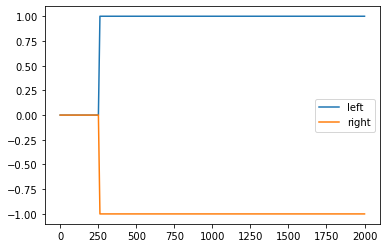

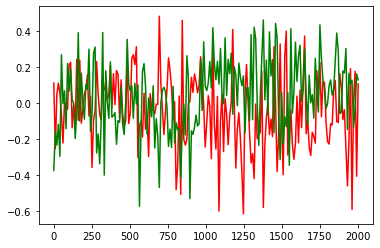

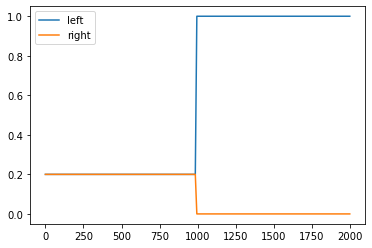

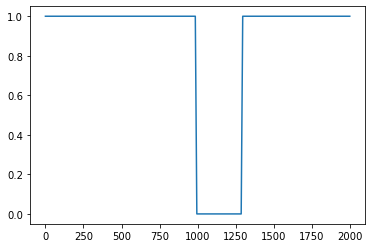

In [11]:
# 1a: left tartet red (-1) or green (+1)
# 1b: right target red (-1) or green (+1)
# 2a: red coherence (-1 to 1) ()
# 2b: green coherence (-1 to 1) (G-R) / (R+G)
trialIn = x[1,:,:]
trialOut = y[1,:,:]
trialMask = mask[1,:,:]
time = np.linspace(0, newChecker.T, int(newChecker.T/newChecker.dt))
# plot input to the model
plt.figure()
plt.plot(time, trialIn[:,0], label = 'left')
plt.plot(time, trialIn[:,1], label = 'right')
plt.legend()

plt.figure()
plt.plot(time, trialIn[:,2], color = 'red')
plt.plot(time, trialIn[:,3], color = 'green')
# plot output to the model
plt.figure()
plt.plot(time, trialOut[:,0], label = 'left')
plt.plot(time, trialOut[:,1], label = 'right')
plt.legend()
# plot trial masks
plt.figure()
plt.plot(time, trialMask[:,0])

In [12]:
# get all parameters for the task
params = newChecker.get_task_params();
print(params)

{'N_batch': 128, 'N_in': 4, 'N_out': 2, 'dt': 10, 'tau': 20, 'T': 2000, 'alpha': 0.5, 'N_steps': 200, 'coherence': [-0.9, 0.9], 'side': 0.5, 'noise': 0.25, 'target_onset': [250, 500], 'checker_onset': [500, 1000], 'accumulation_mask': 300, 'decision_threshold': 0.7, 'post_decision_baseline': 0.2, 'wait': 0.2, 'hi': 1, 'lo': 0}


# # Test model parameters

In [17]:
## vars(Object_name) check all attributes and value
from __future__ import division

from psychrnn.backend.models.basic import Basic
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [23]:
rnn_inputs = tf.unstack(x, axis=1)


In [18]:
params['name'] = 'model'
params['N_rec'] = 100
model = Basic(params)
# check initializer of value
test = model.initializer


In [23]:
train_params = {}
train_params['save_weights_path'] =  "./weights"
train_params['training_iters'] = 10000
model.train(batchTrials, train_params)

Iter 1280, Minibatch Loss= 0.052049
Iter 2560, Minibatch Loss= 0.023568
Iter 3840, Minibatch Loss= 0.016639
Iter 5120, Minibatch Loss= 0.014863
Iter 6400, Minibatch Loss= 0.012507
Iter 7680, Minibatch Loss= 0.011038
Iter 8960, Minibatch Loss= 0.007520
Optimization finished!
Model saved in file: ./weights


([0.05204875,
  0.023567704,
  0.01663918,
  0.014863422,
  0.012507212,
  0.0110379625,
  0.007519829],
 40.64294123649597,
 8.514878749847412)

In [24]:
# test the model
model_output, model_state = model.test(x) # run the model on input x

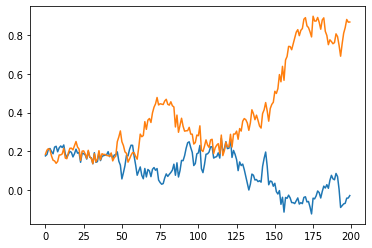

In [34]:
plt.plot(model_output[0,:,:])

In [30]:
# use the trained weight; create another model
params['load_weights_path'] = "./weights.npz"
model2 = Basic(params)


In [32]:
# run a test on the trained model
model_output2, model_state2 = model2.test(x) # run the model on input x

In [37]:
model2.destruct()

In [29]:
a = np.random.uniform(0,1, size = (1,1))
type(a)

numpy.ndarray